In [1]:
import pandas as pd
import numpy as np
#import utils
import io
import os
import itertools
import matplotlib.pyplot as plt
import time
import math
import unidecode
import requests
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import norm, skew, pearsonr #for some statistics
from bs4 import BeautifulSoup
import re
import sys, getopt
import csv
import random
from collections import Counter
pd.set_option('display.max_columns', None)

pd.options.display.max_columns=999

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Function to scrape FBRef for the last five games
### Functions to make finished spreadsheets for plain xG and p90 xG, respectively

In [2]:
### Function to scrape FBRef for the last five games
### Functions to make finished spreadsheets for plain xG and p90 xG, respectively
def scrapeURL(url, homeoraway):
    res = requests.get(url)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tbody")

    if (homeoraway == "home"):
        summary_table = all_tables[0] # 'player', minutes', 'goals', 'assists', 'shots_total', shots_on_target', 'xg', 'xa'
        passing_table = all_tables[1] # 'assisted_shots', 'passes_completed'
        misc_table = all_tables[5] # 'crosses' ,'fouled', 'fouls', 'tackles_won', 'interceptions', 'cards_yellow', 'cards_red'
    elif (homeoraway == "away"):
        summary_table = all_tables[7]
        passing_table = all_tables[8]
        misc_table = all_tables[12]
    #else:
    #    return("Have to supply home or away")

    # parse each table and create dict
    pre_df_player = dict()
    features_from_summary =["shirtnumber", "minutes", "goals", "assists", "shots_total", "shots_on_target", "xg", "xa"]
    features_from_passing = ["assisted_shots", "passes_completed"]
    features_from_misc = ["crosses", "fouled", "fouls", "tackles_won", "interceptions", "cards_yellow"]

    rows_summary = summary_table.find_all('tr')
    rows_passing = passing_table.find_all('tr')
    rows_misc = misc_table.find_all('tr')
    for row in range(len(rows_summary)):
        # get the names of each player
        cell = rows_summary[row].find("th", {"data-stat": "player"})
        text = cell.text.strip()
        text = unidecode.unidecode(text)
        if "player" in pre_df_player:
            pre_df_player["player"].append(text)
        else:
            pre_df_player["player"] = [text]

        #print(rows_summary[row].findAll('th')[0].text)
        if ('\xa0' in rows_summary[row].findAll('th')[0].text):
            if 'subs' in pre_df_player:
                pre_df_player['subs'].append(1)
                pre_df_player['starts'].append(0)
            else:
                pre_df_player['subs'] = [1]
                pre_df_player['starts'] = [0]
        else:
            if 'starts' in pre_df_player:
                pre_df_player['subs'].append(0)
                pre_df_player['starts'].append(1)
            else:
                pre_df_player['subs'] = [0]
                pre_df_player['starts'] = [1]

        for feature in features_from_summary:
            cell = rows_summary[row].find("td", {"data-stat": feature})
            if cell.text == "":
                stat = 0.0
            else:
                stat = float(cell.text)
            if feature in pre_df_player:
                pre_df_player[feature].append(stat)
            else:
                pre_df_player[feature] = [stat]

        for feature in features_from_passing:
            cell = rows_passing[row].find("td", {"data-stat": feature})
            if cell.text == "":
                stat = 0.0
            else:
                stat = float(cell.text)
            if feature in pre_df_player:
                pre_df_player[feature].append(stat)
            else:
                pre_df_player[feature] = [stat]

        for feature in features_from_misc:
            cell = rows_misc[row].find("td", {"data-stat": feature})
            if cell.text == "":
                stat = 0.0
            else:
                stat = float(cell.text)
            if feature in pre_df_player:
                pre_df_player[feature].append(stat)
            else:
                pre_df_player[feature] = [stat]

    df_player = pd.DataFrame.from_dict(pre_df_player)
    df_player = df_player.set_index("player").sort_values(by="player")

    #df_player['starts'] = 0
    df_player['Start_Mins'] = 0
    #df_player['subs'] = 0
    df_player['Sub_Mins'] = 0
    df_player['FPTS'] = df_player['goals']*10 + df_player['assists']*6 + \
                        df_player['shots_total'] + df_player['shots_on_target'] + \
                        df_player['assisted_shots'] + df_player['passes_completed']*0.02 + \
                        df_player['crosses']*0.7 + df_player['fouled'] - \
                        df_player['fouls']*0.5 + df_player['tackles_won'] + \
                        df_player['interceptions']*0.5 - df_player['cards_yellow']*1.5

    df_player['FPTS_min'] = np.nan
    for name in df_player.index:
        df_player.loc[name,'FPTS_min'] = ( df_player.loc[name]['FPTS'] / max(30,df_player.loc[name]['minutes']) )*90
    for name in df_player.index:
        if ((df_player.loc[name]['minutes'] >= 45) and (df_player.loc[name]['starts'] == 1)):
            df_player.loc[name, 'Start_Mins'] = df_player.loc[name]['minutes']
        elif ((df_player.loc[name]['minutes'] <= 45) and (df_player.loc[name]['starts'] == 1)):
            df_player.loc[name, 'starts'] = df_player.loc[name]['starts'] - 1
        elif ((df_player.loc[name]['minutes'] <= 45) and (df_player.loc[name]['subs'] == 1)):
            df_player.loc[name, 'Sub_Mins'] = df_player.loc[name]['minutes']
        elif ((df_player.loc[name]['minutes'] >= 45) and (df_player.loc[name]['subs'] == 1)):
            df_player.loc[name, 'subs'] = df_player.loc[name]['subs'] - 1
    return(df_player)
    #return(pre_df_player)


def make_finished_spreadsheet(starters, home_abbrev, away_abbrev, predictions_matrix, model):
    starters["90s"] = starters["90s"].astype('float')
    for i in range(len(starters)):
        if (starters["90s"][i] > 67.5):
            starters["90s"][i] = starters["90s"][i]/90
        else:
            starters["90s"][i] = 0.75
    starters["Floor"] = (starters["Sh"] + starters["SoT"] + starters["Crs"]*0.7 + starters["KP"] + starters["Pass_Cmp"]*0.02 + starters["Fld"] - starters["Fls"]*0.5 + starters["TklW"] + starters["Int"]*0.5) / starters["90s"]
    starters["FPTS"] = (starters["Gls"]*10 + starters["Ast"]*6 + starters["Sh"] + starters["SoT"] + starters["Crs"]*0.7 + starters["KP"] + starters["Pass_Cmp"]*0.02 + starters["Fld"] - starters["Fls"]*0.5 + starters["TklW"] + starters["Int"]*0.5 - starters["CrdY"]*1.5) / starters["90s"]

    # Minutes (to simplify some calculations)
    starters["Proj_Mins"] = 0.1
    for i in range(len(starters)):
        if (starters["Starting"][i] == "y"):
            starters["Proj_Mins"][i] = starters["Start_Mins"][i]
        else:
            starters["Proj_Mins"][i] = starters["Sub_Mins"][i]
    
    # xG
    starters["xG_p90"] = starters['xG']/starters['90s'] # create a p90 column for the stat
    starters["Raw_Goals"] = starters["xG_p90"] * (starters['Proj_Mins']/90) # this is (stat_p90)*projmins
    home_stat = sum(starters[starters['Team'] == home_abbrev]["Raw_Goals"]) # get the sum (stat_p90)*proj_mins for each team
    away_stat = sum(starters[starters['Team'] == away_abbrev]["Raw_Goals"])
    starters['Goal_Share'] = 0.1
    for i in range(len(starters['Player'])):
        if (starters['Team'][i] == home_abbrev):
            starters['Goal_Share'][i] = starters['Raw_Goals'][i] / home_stat
        else:
            starters['Goal_Share'][i] = starters['Raw_Goals'][i] / away_stat
    starters['Team_Goal_Proj'] = 0.1
    for i in range(len(starters['Player'])):
        if (starters["Team"][i] == home_abbrev):
            starters["Team_Goal_Proj"][i] = predictions_matrix["Real_Goals"][0]
        else:
            starters["Team_Goal_Proj"][i] = predictions_matrix["Real_Goals"][1]
    starters['Proj_Gls'] = starters['Goal_Share'] * starters['Team_Goal_Proj']

    # xA
    starters["xA_p90"] = starters['xA']/starters['90s'] # create a p90 column for the stat
    starters["Raw_Ast"] = starters["xA_p90"] * (starters['Proj_Mins']/90) # this is (stat_p90)*projmins
    home_stat = sum(starters[starters['Team'] == home_abbrev]["Raw_Ast"]) # get the sum (stat_p90)*proj_mins for each team
    away_stat = sum(starters[starters['Team'] == away_abbrev]["Raw_Ast"])
    starters['Ast_Share'] = 0.1
    for i in range(len(starters['Player'])):
        if (starters['Team'][i] == home_abbrev):
            starters['Ast_Share'][i] = starters['Raw_Ast'][i] / home_stat
        else:
            starters['Ast_Share'][i] = starters['Raw_Ast'][i] / away_stat
    starters['Team_Ast_Proj'] = 0.1
    for i in range(len(starters['Player'])):
        if (starters["Team"][i] == home_abbrev):
            starters["Team_Ast_Proj"][i] = predictions_matrix["Real_Goals"][0]
        else:
            starters["Team_Ast_Proj"][i] = predictions_matrix["Real_Goals"][1]
    starters['Proj_Ast'] = starters['Ast_Share'] * starters['Team_Ast_Proj']


    # NonGoal Stats
    statnames = ['Sh', 'SoT', 'KP', 'Fls', 'Fld', 'Crs', 'TklW', 'Int']
    for stat in statnames:
        starters[stat+"_p90"] = starters[stat]/starters['90s'] # create a p90 column for the stat
        starters["Raw_"+stat] = starters[stat+"_p90"] * starters['Proj_Mins'] # this is (stat_p90)*projmins
        home_stat = sum(starters[starters['Team'] == home_abbrev]["Raw_"+stat]) # get the sum (stat_p90)*proj_mins for each team
        away_stat = sum(starters[starters['Team'] == away_abbrev]["Raw_"+stat])
        starters[stat+'_Share'] = 0.1
        for i in range(len(starters['Player'])):
            if (starters['Team'][i] == home_abbrev):
                starters[stat+'_Share'][i] = starters['Raw_'+stat][i] / home_stat
            else:
                starters[stat+'_Share'][i] = starters['Raw_'+stat][i] / away_stat
        starters['Team_'+stat+'_Proj'] = 0.1
        for i in range(len(starters['Player'])):
            if (starters["Team"][i] == home_abbrev):
                starters["Team_"+stat+"_Proj"][i] = predictions_matrix["Real_"+stat][0]
            else:
                starters["Team_"+stat+"_Proj"][i] = predictions_matrix["Real_"+stat][1]
        starters['Proj_'+stat] = starters[stat+'_Share'] * starters['Team_'+stat+'_Proj']   
        

    # Fill NA's with zeros for later arithmetic
    starters = starters.fillna(0)

    # Pts_w_StartMins
    starters["Pts_w_StartMins"] = 0.1
    for i in range(len(starters["Player"])):
        if (starters["Starting"][i] == "y"):
            starters["Pts_w_StartMins"][i] = starters["Proj_Gls"][i]*10 + starters["Proj_Ast"][i]*6 + \
                                             starters["Proj_Sh"][i] + starters["Proj_SoT"][i] +    \
                                             starters["Proj_KP"][i] + starters["Proj_Crs"][i]*0.7 +   \
                                             starters["Proj_Fld"][i] - starters["Proj_Fls"][i]*0.5 +  \
                                             starters["Proj_TklW"][i] + starters["Proj_Int"][i]*0.5 + \
                                            (starters["Pass_Cmp"][i]*0.02)/starters["90s"][i] *(starters["Start_Mins"][i]/90)
        else:
            starters["Pts_w_StartMins"][i] = starters["Proj_Gls"][i]*10 + starters["Proj_Ast"][i]*6 + \
                                             starters["Proj_Sh"][i] + starters["Proj_SoT"][i] +    \
                                             starters["Proj_KP"][i] + starters["Proj_Crs"][i]*0.7 +   \
                                             starters["Proj_Fld"][i] - starters["Proj_Fls"][i]*0.5 +  \
                                             starters["Proj_TklW"][i] + starters["Proj_Int"][i]*0.5 + \
                                            (starters["Pass_Cmp"][i]*0.02)/starters["90s"][i] * (starters["Sub_Mins"][i]/90)

    starters["Player_"] = starters["Player"] # add name column on right side for easy reading
    starters = starters.sort_values(by="Pts_w_StartMins", ascending=False).reset_index().drop(columns=["index"])

    cols = ["Player", "Team", "Pos", "Salary", "90s", "Gls", "Ast", "Sh", "SoT", "Crs", "KP", "Pass_Cmp",
            "Fld", "Fls", "TklW", "Int", "CrdY", "Floor", "FPTS", "FPTS_med", "xG", "xA",
            "Raw_Goals", "Goal_Share", "Team_Goal_Proj", "Proj_Gls",
            "Raw_Ast", "Ast_Share", "Team_Ast_Proj", "Proj_Ast",
            "Raw_Sh", "Sh_Share", "Team_Sh_Proj", "Proj_Sh",
            "Raw_SoT", "SoT_Share", "Team_SoT_Proj", "Proj_SoT",
            "Raw_KP", "KP_Share", "Team_KP_Proj", "Proj_KP",
            "Raw_Crs", "Crs_Share", "Team_Crs_Proj", "Proj_Crs",
            "Raw_Fld", "Fld_Share", "Team_Fld_Proj", "Proj_Fld",
            "Raw_Fls", "Fls_Share", "Team_Fls_Proj", "Proj_Fls",
            "Raw_TklW", "TklW_Share", "Team_TklW_Proj", "Proj_TklW",
            "Raw_Int", "Int_Share", "Team_Int_Proj", "Proj_Int",
            "Pts_w_StartMins", "Start_Mins", "Sub_Mins", "Starting", "starts", "subs", "Player_"]
    starters = starters[cols]
    
    starters['Proj_Mins'] = np.nan
    for i in starters.index:
        if (starters['Starting'][i] == 'y'): starters['Proj_Mins'][i] = starters['Start_Mins'][i]
        elif (starters['Starting'][i] == 'b'): starters['Proj_Mins'][i] = starters['Sub_Mins'][i]

    y_pred = model.predict(np.array(starters[['Salary','Pts_w_StartMins','Proj_Mins']]))
    starters['Reg_Pts'] = y_pred
    starters['FPTS_med_w_mins'] = starters['FPTS_med'] * (starters['Proj_Mins'] / 90)

    starters = starters.sort_values(by='Reg_Pts', ascending=False).reset_index().drop(columns=['index'])

    starters.to_csv("Matchup_Spreadsheets/"+league+'/'+home_abbrev+"_"+away_abbrev+"_"+date+"_spreadsheet_finished.csv")

    return(starters)

### Scrape the last five games and write out the basic stats

In [179]:
league = 'Bundesliga'
#fbref_league = 'LaLiga'
fbref_league = league
regression_league = 'Bundesliga'

home_full = "Greuther Fürth" # Enter the full name of the teams, as they appear in the shotlog.csv files
away_full = "Eint Frankfurt"

#home_abbrev = "CLB"
#away_abbrev = "RBNY"

date = "20211107" # Use form YYYYMMDD


teamname_df = pd.read_csv('TeamNameConventions.csv')
name_to_url = {}
name_to_abbrev = {}
for i in range(len(teamname_df)):
    name_to_url[teamname_df['FBRef'][i]] = teamname_df['FBRef_URL'][i]
    name_to_abbrev[teamname_df['FBRef'][i]] = teamname_df['DK_Abbrev'][i]

home_abbrev = name_to_abbrev[home_full]
away_abbrev = name_to_abbrev[away_full]
print(home_abbrev, 'vs.', away_abbrev)
homeurl = name_to_url[home_full]
awayurl = name_to_url[away_full]
print(homeurl)
print(awayurl)

prevgames = 8


SGF vs. SGE
https://fbref.com/en/squads/12192a4c/Greuther-Furth-Stats
https://fbref.com/en/squads/f0ac8ee6/Eintracht-Frankfurt-Stats


In [180]:
# The league name in FBRef has spaces, the one we provide in order to
# also search filenames does not
if (league == 'LaLiga'): fbref_league = 'LaLiga'
elif (league == 'PremierLeague'): fbref_league = 'PremierLeague'
elif (league == 'SerieA'): fbref_league = 'SerieA'
elif (league == 'Ligue1'): fbref_league = 'Ligue1'
else: league = fbref_league
    
if (league == 'MLS'): a = 1 # this is for a weird bug in CF Montreal's fbref page where the first game is blank
else: a = 0

# scrape in the url of the last 5 matches played (in the league) for the home and away teams, and indicate if they were home or away
home_urls = ['']*prevgames
home_homeoraways = ['']*prevgames
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
res = requests.get(homeurl, headers=headers)
## The next two lines get around the issue with comments breaking the parsing
comm = re.compile("<!--|-->")
soup = BeautifulSoup(comm.sub("",res.text),'lxml')
all_tables = soup.findAll("tbody")
for i in range(a, len(all_tables[1].findAll("tr"))):
    game_date = all_tables[1].findAll("tr")[i].findAll("a", href=True)[0].text.replace('-', '')
    if (game_date.isnumeric()):
        game_date_int = int(game_date)
        #print(game_date_int)
    note = all_tables[1].findAll("tr")[i].findAll('td', {'data-stat':'notes'})[0].text
    if ((not game_date.isnumeric() and (note == '')) or (game_date == date)):
        break
ctr=0
for k in reversed(range(i)):
    if (ctr == prevgames):
        break
    if (all_tables[1].findAll("tr")[k].findAll("a", href=True)[1].text.replace(' ', '') == fbref_league):
        home_urls[ctr] = 'https://fbref.com/' + all_tables[1].findAll("tr")[k].findAll("a", href=True)[0]['href']
        home_homeoraways[ctr] = all_tables[1].findAll("tr")[k].findAll("td", {"data-stat":"venue"})[0].text.lower()
        ctr+=1

away_urls = ['']*prevgames
away_homeoraways = ['']*prevgames
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
res = requests.get(awayurl, headers=headers)
## The next two lines get around the issue with comments breaking the parsing
comm = re.compile("<!--|-->")
soup = BeautifulSoup(comm.sub("",res.text),'lxml')
all_tables = soup.findAll("tbody")

for i in range(a, len(all_tables[1].findAll("tr"))):
    game_date = all_tables[1].findAll("tr")[i].findAll("a", href=True)[0].text.replace('-', '')
    if (game_date.isnumeric()):
        game_date_int = int(game_date)
    note = all_tables[1].findAll("tr")[i].findAll('td', {'data-stat':'notes'})[0].text
    if ((not game_date.isnumeric() and (note == '')) or (game_date == date)):
        break

ctr=0
for k in reversed(range(i)):
    if (ctr == prevgames):
        break
    if (all_tables[1].findAll("tr")[k].findAll("a", href=True)[1].text.replace(' ', '') == fbref_league):
        away_urls[ctr] = 'https://fbref.com/' + all_tables[1].findAll("tr")[k].findAll("a", href=True)[0]['href']
        away_homeoraways[ctr] = all_tables[1].findAll("tr")[k].findAll("td", {"data-stat":"venue"})[0].text.lower()
        ctr+=1

# COMMENT THESE OUT IF PREPARING FOR GAME THAT HAS NOT YET OCCURRED
#home_urls = home_urls[1:]
#home_homeoraways = home_homeoraways[1:]
#away_urls = away_urls[1:]
#away_homeoraways = away_homeoraways[1:]
#prevgames = prevgames-1

# alright now you're good to run the cell
##################################################################################################################
print(home_urls)

home_stats = scrapeURL(home_urls[0], home_homeoraways[0])
home_fpts = {}
for name in home_stats.index:
    home_fpts[name] = [home_stats.loc[name,'FPTS_min']]
for i in range(1,prevgames):
    print(home_urls[i])
    tmp = scrapeURL(home_urls[i], home_homeoraways[i])
    for name in tmp.index:
        if name in home_stats.index:
            home_fpts[name] = home_fpts[name] + [tmp.loc[name,'FPTS_min']]
            for col in home_stats.columns:
                home_stats.loc[name,col] = home_stats.loc[name][col] + tmp.loc[name][col]
        else:
            home_fpts[name] = [tmp.loc[name,'FPTS_min']]
            home_stats = home_stats.append(tmp.loc[name])
            #if (tmp.loc[name]['minutes'] >= 45):
            #    home_stats.loc[name]['starts'] = 1
            #    home_stats.loc[name]['Start_Mins'] = tmp.loc[name]['minutes']
            #else:
            #    home_stats.loc[name]['subs'] = 1
            #    home_stats.loc[name]['Sub_Mins'] = tmp.loc[name]['minutes']
home_stats["Team"] = home_abbrev

print(away_urls)
away_stats = scrapeURL(away_urls[0], away_homeoraways[0])
away_fpts = {}
for name in away_stats.index:
    away_fpts[name] = [away_stats.loc[name,'FPTS_min']]
for i in range(1,prevgames):
    print(away_urls[i])
    tmp = scrapeURL(away_urls[i], away_homeoraways[i])
    for name in tmp.index:
        if name in away_stats.index:
            away_fpts[name] = away_fpts[name] + [tmp.loc[name,'FPTS_min']]
            for col in away_stats.columns:
                away_stats.loc[name,col] = away_stats.loc[name][col] + tmp.loc[name][col]
        else:
            away_fpts[name] = [tmp.loc[name,'FPTS_min']]
            away_stats = away_stats.append(tmp.loc[name])      
away_stats["Team"] = away_abbrev
#away_stats = away_stats.sort_values(by="minutes")

full_stats = pd.concat([home_stats, away_stats])
full_stats["Pos"] = np.nan
full_stats["Salary"] = np.nan
full_stats["Start_Mins"] = full_stats['Start_Mins'] / full_stats['starts']
full_stats["Sub_Mins"] = full_stats['Sub_Mins'] / full_stats['subs']
full_stats["Starting"] = 'y'
full_stats = full_stats.drop(labels="shirtnumber", axis=1)
#full_stats = full_stats.reset_index()
full_stats = full_stats.rename(columns={"player": "Player",
                                        "minutes":"90s",
                                        "goals":"Gls",
                                        "assists":"Ast",
                                        "shots_total":"Sh",
                                        "shots_on_target":"SoT",
                                        "crosses":"Crs",
                                        "assisted_shots":"KP",
                                        "passes_completed":"Pass_Cmp",
                                        "fouled":"Fld",
                                        "fouls":"Fls",
                                        "tackles_won":"TklW",
                                        "interceptions":"Int",
                                        "cards_yellow":"CrdY",
                                        "xg":"xG",
                                        "xa":"xA"})

cols = ["Team", "Pos", "Salary", "90s", "Gls", "Ast", "Sh", "SoT", "Crs", "KP", "Pass_Cmp", "Fld", "Fls",
        "TklW", "Int", "CrdY", "xG", "xA", "Start_Mins", "Sub_Mins", "Starting", "starts", "subs"]
full_stats = full_stats[cols]
full_stats['FPTS_stdev'] = np.nan
full_stats['FPTS_med'] = np.nan
for name in full_stats[full_stats['Team'] == home_abbrev].index:
    full_stats.loc[name,'FPTS_stdev'] = np.array(home_fpts[name]).std()
    full_stats.loc[name,'FPTS_med'] = np.median(home_fpts[name])
for name in full_stats[full_stats['Team'] == away_abbrev].index:
    full_stats.loc[name,'FPTS_stdev'] = np.array(away_fpts[name]).std()
    full_stats.loc[name,'FPTS_med'] = np.median(away_fpts[name])

['https://fbref.com//en/matches/1b975160/Freiburg-Greuther-Furth-October-30-2021-Bundesliga', 'https://fbref.com//en/matches/b1bb1224/RB-Leipzig-Greuther-Furth-October-23-2021-Bundesliga', 'https://fbref.com//en/matches/ab41b4b4/Greuther-Furth-Bochum-October-16-2021-Bundesliga', 'https://fbref.com//en/matches/c3c10403/Koln-Greuther-Furth-October-1-2021-Bundesliga', 'https://fbref.com//en/matches/2def9292/Greuther-Furth-Bayern-Munich-September-24-2021-Bundesliga', 'https://fbref.com//en/matches/7044d252/Hertha-BSC-Greuther-Furth-September-17-2021-Bundesliga', 'https://fbref.com//en/matches/ab5fbcdf/Greuther-Furth-Wolfsburg-September-11-2021-Bundesliga', 'https://fbref.com//en/matches/359314e5/Mainz-05-Greuther-Furth-August-28-2021-Bundesliga']
https://fbref.com//en/matches/b1bb1224/RB-Leipzig-Greuther-Furth-October-23-2021-Bundesliga
https://fbref.com//en/matches/ab41b4b4/Greuther-Furth-Bochum-October-16-2021-Bundesliga
https://fbref.com//en/matches/c3c10403/Koln-Greuther-Furth-October-

In [181]:
full_stats

,Team,Pos,Salary,90s,Gls,Ast,Sh,SoT,Crs,KP,Pass_Cmp,Fld,Fls,TklW,Int,CrdY,xG,xA,Start_Mins,Sub_Mins,Starting,starts,subs,FPTS_stdev,FPTS_med
player,,,,,,,,,,,,,,,,,,,,,,,,,
Abdourahmane Barry,SGF,NaN,NaN,101.0,0.0,0.0,1.0,0.0,4.0,0.0,43.0,2.0,4.0,3.0,5.0,2.0,0.0,0.0,NaN,20.200000,y,0.0,5.0,7.202360,5.460000
Branimir Hrgota,SGF,NaN,NaN,635.0,2.0,1.0,7.0,2.0,8.0,13.0,120.0,17.0,9.0,7.0,5.0,1.0,2.1,1.5,79.375000,NaN,y,8.0,0.0,6.531029,9.100000
Cedric Itten,SGF,NaN,NaN,438.0,1.0,0.0,10.0,7.0,4.0,3.0,59.0,6.0,12.0,6.0,0.0,1.0,1.1,0.1,79.000000,21.500000,y,5.0,2.0,12.330973,4.700000
Gian-Luca Itter,SGF,NaN,NaN,87.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,45.000000,14.000000,y,1.0,3.0,0.810972,0.360000
Hans Nunoo Sarpei,SGF,NaN,NaN,270.0,0.0,0.0,1.0,0.0,0.0,0.0,111.0,10.0,1.0,8.0,8.0,0.0,0.0,0.0,90.000000,NaN,y,3.0,0.0,1.479459,8.480000
Jamie Leweling,SGF,NaN,NaN,284.0,1.0,0.0,7.0,3.0,7.0,2.0,34.0,9.0,4.0,1.0,3.0,0.0,0.8,0.1,90.000000,17.333333,y,2.0,6.0,5.668710,6.660000
Jetro Willems,SGF,NaN,NaN,523.0,0.0,0.0,4.0,0.0,11.0,4.0,163.0,2.0,6.0,11.0,7.0,0.0,0.1,0.4,74.714286,NaN,y,7.0,0.0,2.001177,5.575610
Julian Green,SGF,NaN,NaN,302.0,0.0,0.0,4.0,3.0,9.0,4.0,74.0,8.0,5.0,4.0,7.0,1.0,0.0,0.1,69.500000,24.000000,y,4.0,1.0,4.644422,8.448000
Marius Funk,SGF,NaN,NaN,360.0,0.0,0.0,0.0,0.0,0.0,2.0,109.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1,90.000000,NaN,y,4.0,0.0,0.351852,0.910000


In [184]:
## ADJUST SALARY SHEET FOR :
### Arsenal - Martin Odegaard
### Brentford - Christian Norgaard
### Brentford - Mads Bech Sorensen
### Brighton - Pascal Gross
### Tottenham - Pierre-Emile Hojbjerg
filename = 'DK_Salaries/' + league + '/' + home_abbrev + '_' + away_abbrev + '_' + date + '_Salaries.csv'
DK_Salaries = pd.read_csv(filename, encoding = "ISO-8859-1")
for i in range(len(DK_Salaries)):
    if (('Martin ' in DK_Salaries['Name'][i]) & ('degaard' in DK_Salaries['Name'][i])): DK_Salaries['Name'][i] = 'Martin Odegaard'
    elif (('Christian N' in DK_Salaries['Name'][i]) & ('rgaard' in DK_Salaries['Name'][i])): DK_Salaries['Name'][i] = 'Christian Norgaard'
    elif (('Mads Bech S' in DK_Salaries['Name'][i]) & ('rensen' in DK_Salaries['Name'][i])): DK_Salaries['Name'][i] = 'Mads Bech Sorensen'
    elif ('Pascal Gro' in DK_Salaries['Name'][i]): DK_Salaries['Name'][i] = 'Pascal Gross'
    elif (('Pierre-Emile H' in DK_Salaries['Name'][i]) & ('jbjerg' in DK_Salaries['Name'][i])): DK_Salaries['Name'][i] = 'Pierre-Emile Hojbjerg'
    elif (('Alexander S' in DK_Salaries['Name'][i]) & ('rloth' in DK_Salaries['Name'][i])): DK_Salaries['Name'][i] = 'Alexander Sorloth'
    elif (('Niko Gie' in DK_Salaries['Name'][i]) & ('elmann' in DK_Salaries['Name'][i])): DK_Salaries['Name'][i] = 'Niko Giesselmann'
    elif (('Noah Wei' in DK_Salaries['Name'][i]) & ('haupt' in DK_Salaries['Name'][i])): DK_Salaries['Name'][i] = 'Noah Weisshaupt'
    elif (('Bj' in DK_Salaries['Name'][i]) & ('rn Johnsen' in DK_Salaries['Name'][i])): DK_Salaries['Name'][i] = 'Bjorn Johnsen'
DK_Salaries.to_csv(filename, index=False)


NameMatching = pd.read_csv("NameMatching.csv", encoding = "ISO-8859-1")
fbref_to_dk = {}
for i in range(len(NameMatching)):
    if (pd.notna(NameMatching['FBRef'][i])):
        fbref_to_dk[NameMatching['FBRef'][i]] = NameMatching['Name'][i]



ctr = 0
for fbref_name in list(full_stats.index):
    if (fbref_name not in fbref_to_dk):
        if (fbref_name in list(DK_Salaries['Name'])):
            idx = DK_Salaries[DK_Salaries['Name'] == fbref_name].index[0]
            fbref_to_dk[fbref_name] = DK_Salaries['Name'][idx]
            missing = league + ',' + full_stats['Team'][fbref_name] + ',' + DK_Salaries['Position'][idx] + ',,' + DK_Salaries['Name'][idx] + ',,,,' + fbref_name
            print(missing)
            ctr+=1
if (ctr == 0): print("No players missing")
            
print('')
print('Still Missing:')
ctr=0
for fbref_name in list(full_stats.index):
    if (fbref_name not in fbref_to_dk):
        print(fbref_name)
        ctr+=1
if (ctr == 0): print("None still missing")



No players missing

Still Missing:
None still missing


In [185]:
## MAKE SURE THE NAMEMATCHING CSV IS UPDATED AT THIS POINT
NameMatching = pd.read_csv("NameMatching.csv", encoding = "ISO-8859-1")
fbref_to_dk = {}
for i in range(len(NameMatching)):
    if (pd.notna(NameMatching['FBRef'][i])):
        fbref_to_dk[NameMatching['FBRef'][i]] = NameMatching['Name'][i]
        
for fbref_name in list(full_stats.index):
    if (fbref_name not in fbref_to_dk):
        fbref_to_dk[fbref_name] = ''
        #print(fbref_name, 'dropped')
        
for name in list(full_stats.index):
    #if (name not in list(DK_Salaries['Name'])):
    if (fbref_to_dk[name] not in list(DK_Salaries['Name'])):
        full_stats = full_stats.drop(name)
        print(name, "dropped")
full_stats

,Team,Pos,Salary,90s,Gls,Ast,Sh,SoT,Crs,KP,Pass_Cmp,Fld,Fls,TklW,Int,CrdY,xG,xA,Start_Mins,Sub_Mins,Starting,starts,subs,FPTS_stdev,FPTS_med
player,,,,,,,,,,,,,,,,,,,,,,,,,
Abdourahmane Barry,SGF,NaN,NaN,101.0,0.0,0.0,1.0,0.0,4.0,0.0,43.0,2.0,4.0,3.0,5.0,2.0,0.0,0.0,NaN,20.200000,y,0.0,5.0,7.202360,5.460000
Branimir Hrgota,SGF,NaN,NaN,635.0,2.0,1.0,7.0,2.0,8.0,13.0,120.0,17.0,9.0,7.0,5.0,1.0,2.1,1.5,79.375000,NaN,y,8.0,0.0,6.531029,9.100000
Cedric Itten,SGF,NaN,NaN,438.0,1.0,0.0,10.0,7.0,4.0,3.0,59.0,6.0,12.0,6.0,0.0,1.0,1.1,0.1,79.000000,21.500000,y,5.0,2.0,12.330973,4.700000
Gian-Luca Itter,SGF,NaN,NaN,87.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,45.000000,14.000000,y,1.0,3.0,0.810972,0.360000
Hans Nunoo Sarpei,SGF,NaN,NaN,270.0,0.0,0.0,1.0,0.0,0.0,0.0,111.0,10.0,1.0,8.0,8.0,0.0,0.0,0.0,90.000000,NaN,y,3.0,0.0,1.479459,8.480000
Jamie Leweling,SGF,NaN,NaN,284.0,1.0,0.0,7.0,3.0,7.0,2.0,34.0,9.0,4.0,1.0,3.0,0.0,0.8,0.1,90.000000,17.333333,y,2.0,6.0,5.668710,6.660000
Jetro Willems,SGF,NaN,NaN,523.0,0.0,0.0,4.0,0.0,11.0,4.0,163.0,2.0,6.0,11.0,7.0,0.0,0.1,0.4,74.714286,NaN,y,7.0,0.0,2.001177,5.575610
Julian Green,SGF,NaN,NaN,302.0,0.0,0.0,4.0,3.0,9.0,4.0,74.0,8.0,5.0,4.0,7.0,1.0,0.0,0.1,69.500000,24.000000,y,4.0,1.0,4.644422,8.448000
Marius Funk,SGF,NaN,NaN,360.0,0.0,0.0,0.0,0.0,0.0,2.0,109.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1,90.000000,NaN,y,4.0,0.0,0.351852,0.910000


In [186]:
for name in list(full_stats.index):
    tmp = DK_Salaries[DK_Salaries['Name'] == fbref_to_dk[name]]
    tmp = tmp[tmp['Roster Position'] == 'FLEX']
    full_stats['Pos'][name] = tmp['Position'].iloc[0]
    full_stats['Salary'][name] = tmp['Salary'].iloc[0]

sorter = {home_abbrev:0, away_abbrev:1}
full_stats['TeamRk'] = full_stats['Team'].map(sorter)
full_stats = full_stats.sort_values(by=['TeamRk', 'player']).drop(columns=['TeamRk'])
full_stats.index.names = ['Player']
full_stats.to_csv("Matchup_Spreadsheets/"+league+'/'+home_abbrev+"_"+away_abbrev+"_"+date+"_spreadsheet.csv")
full_stats

,Team,Pos,Salary,90s,Gls,Ast,Sh,SoT,Crs,KP,Pass_Cmp,Fld,Fls,TklW,Int,CrdY,xG,xA,Start_Mins,Sub_Mins,Starting,starts,subs,FPTS_stdev,FPTS_med
Player,,,,,,,,,,,,,,,,,,,,,,,,,
Abdourahmane Barry,SGF,D,3000.0,101.0,0.0,0.0,1.0,0.0,4.0,0.0,43.0,2.0,4.0,3.0,5.0,2.0,0.0,0.0,NaN,20.200000,y,0.0,5.0,7.202360,5.460000
Adrian Fein,SGF,M,3200.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,3.000000,y,0.0,1.0,0.000000,0.120000
Branimir Hrgota,SGF,F,9000.0,635.0,2.0,1.0,7.0,2.0,8.0,13.0,120.0,17.0,9.0,7.0,5.0,1.0,2.1,1.5,79.375000,NaN,y,8.0,0.0,6.531029,9.100000
Cedric Itten,SGF,F,4800.0,438.0,1.0,0.0,10.0,7.0,4.0,3.0,59.0,6.0,12.0,6.0,0.0,1.0,1.1,0.1,79.000000,21.500000,y,5.0,2.0,12.330973,4.700000
Dickson Abiama,SGF,F,4400.0,207.0,0.0,0.0,6.0,1.0,1.0,1.0,19.0,4.0,6.0,3.0,3.0,1.0,0.4,0.2,90.000000,19.500000,y,1.0,6.0,2.475190,4.840000
Gian-Luca Itter,SGF,D,3200.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,45.000000,14.000000,y,1.0,3.0,0.810972,0.360000
Hans Nunoo Sarpei,SGF,M,3600.0,270.0,0.0,0.0,1.0,0.0,0.0,0.0,111.0,10.0,1.0,8.0,8.0,0.0,0.0,0.0,90.000000,NaN,y,3.0,0.0,1.479459,8.480000
Havard Nielsen,SGF,F,4000.0,380.0,0.0,0.0,10.0,2.0,1.0,1.0,53.0,7.0,10.0,7.0,2.0,1.0,0.5,0.0,76.000000,NaN,y,5.0,0.0,1.931352,4.800000
Jamie Leweling,SGF,F,7800.0,284.0,1.0,0.0,7.0,3.0,7.0,2.0,34.0,9.0,4.0,1.0,3.0,0.0,0.8,0.1,90.000000,17.333333,y,2.0,6.0,5.668710,6.660000


### Make a quick regression for projecting player fantasy points
#### Initial predictors are Salary, Projected Points, and Project Minutes
#### Data stored in `PlayerPointsAnalysis2.csv`, with a scraper here to calculate real player points from FBRef from provided URL

In [48]:
points_data = pd.read_csv('PlayerPointsAnalysis2.csv')
points_data = points_data[~pd.isna(points_data['MatchReport_URL'])]

unfilled = points_data[pd.isna(points_data['Real_Pts'])]

for i in unfilled.index:
    if (points_data['Starting'][i] == 'y'): points_data['Proj_Mins'][i] = points_data['Start_Mins'][i]
    elif (points_data['Starting'][i] == 'b'): points_data['Proj_Mins'][i] = points_data['Sub_Mins'][i]

for url in unfilled['MatchReport_URL'].unique():
    match = unfilled[points_data['MatchReport_URL'] == url]
    
    # Time to get stats from fbref
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(url, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tbody")
    
    homedata = match[match['HorA'] == 'H']
    for i in homedata.index:
        found=0
        for player_i in range(len(all_tables[0].findAll('th'))):
            if (unidecode.unidecode(all_tables[0].findAll('th')[player_i].text.replace('\xa0', '')) == points_data['Player'][i]):
                found = 1
                break
        if (found):
            mins = all_tables[0].findAll('td', {'data-stat':'minutes'})[player_i].text
            if (mins.isnumeric()):
                points_data['Real_Mins'][i] = int(mins)
            else:
                #points_data = points_data.drop(index=i)
                continue
            
            goals = int(all_tables[0].findAll('td', {'data-stat':'goals'})[player_i].text)
            assists = int(all_tables[0].findAll('td', {'data-stat':'assists'})[player_i].text)
            shots = int(all_tables[0].findAll('td', {'data-stat':'shots_total'})[player_i].text)
            sot = int(all_tables[0].findAll('td', {'data-stat':'shots_on_target'})[player_i].text)
            passes = 0 if (all_tables[0].findAll('td', {'data-stat':'passes_completed'})[player_i].text == '') else int(all_tables[0].findAll('td', {'data-stat':'passes_completed'})[player_i].text)
            cardsy = int(all_tables[0].findAll('td', {'data-stat':'cards_yellow'})[player_i].text)
            cardsr = int(all_tables[0].findAll('td', {'data-stat':'cards_red'})[player_i].text)
            if (cardsy==2): cardsr=0
            kp = 0 if (all_tables[1].findAll('td', {'data-stat':'assisted_shots'})[player_i].text == '') else int(all_tables[1].findAll('td', {'data-stat':'assisted_shots'})[player_i].text)
            fls = int(all_tables[5].findAll('td', {'data-stat':'fouls'})[player_i].text)
            fld = int(all_tables[5].findAll('td', {'data-stat':'fouled'})[player_i].text)
            crs = int(all_tables[5].findAll('td', {'data-stat':'crosses'})[player_i].text)
            ints = int(all_tables[5].findAll('td', {'data-stat':'interceptions'})[player_i].text)
            tklw = int(all_tables[5].findAll('td', {'data-stat':'tackles_won'})[player_i].text)
            cs = 3 if ((int(soup.findAll('div', {'class':'score'})[1].text) == 0) and (points_data['Pos'][i] == 'D')) else 0
            points_data['Real_Pts'][i] = goals*10 + assists*6 + shots + sot + passes*.02 + kp + fld + crs*0.7 + ints*0.5 + tklw + cs - cardsy*1.5 - cardsr*3 - fls*0.5
            points_data['TeamGoals'][i] = int(soup.findAll('div', {'class':['score']})[0].text)
    
    awaydata = match[match['HorA'] == 'A']
    for i in awaydata.index:
        found=0
        for player_i in range(len(all_tables[7].findAll('th'))):
            if (unidecode.unidecode(all_tables[7].findAll('th')[player_i].text.replace('\xa0', '')) == points_data['Player'][i]):
                found = 1
                break
        if (found):
            points_data['Real_Mins'][i] = int(all_tables[7].findAll('td', {'data-stat':'minutes'})[player_i].text)
            goals = int(all_tables[7].findAll('td', {'data-stat':'goals'})[player_i].text)
            assists = int(all_tables[7].findAll('td', {'data-stat':'assists'})[player_i].text)
            shots = int(all_tables[7].findAll('td', {'data-stat':'shots_total'})[player_i].text)
            sot = int(all_tables[7].findAll('td', {'data-stat':'shots_on_target'})[player_i].text)
            passes = 0 if (all_tables[7].findAll('td', {'data-stat':'passes_completed'})[player_i].text == '') else int(all_tables[7].findAll('td', {'data-stat':'passes_completed'})[player_i].text)
            cardsy = int(all_tables[7].findAll('td', {'data-stat':'cards_yellow'})[player_i].text)
            cardsr = int(all_tables[7].findAll('td', {'data-stat':'cards_red'})[player_i].text)
            if (cardsy==2): cardsr=0
            kp = 0 if (all_tables[8].findAll('td', {'data-stat':'assisted_shots'})[player_i].text == '') else int(all_tables[8].findAll('td', {'data-stat':'assisted_shots'})[player_i].text)
            fls = int(all_tables[12].findAll('td', {'data-stat':'fouls'})[player_i].text)
            fld = int(all_tables[12].findAll('td', {'data-stat':'fouled'})[player_i].text)
            crs = int(all_tables[12].findAll('td', {'data-stat':'crosses'})[player_i].text)
            ints = int(all_tables[12].findAll('td', {'data-stat':'interceptions'})[player_i].text)
            tklw = int(all_tables[12].findAll('td', {'data-stat':'tackles_won'})[player_i].text)
            cs = 3 if ((int(soup.findAll('div', {'class':'score'})[0].text) == 0) and (points_data['Pos'][i] == 'D')) else 0
            points_data['Real_Pts'][i] = goals*10 + assists*6 + shots + sot + passes*.02 + kp + fld + crs*0.7 + ints*0.5 + tklw + cs - cardsy*1.5 - cardsr*3 - fls*0.5
            points_data['TeamGoals'][i] = int(soup.findAll('div', {'class':['score']})[1].text)
            
points_data = points_data[~pd.isna(points_data['Real_Pts'])].reset_index().drop(columns=['index'])
points_data.to_csv('PlayerPointsAnalysis2.csv', index=False)

#for x in [.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]:
    #print('')
    #print('Exponential Value:', x)
    #points_data = pd.read_csv('PlayerPointsAnalysis2.csv')
points_data = points_data[points_data['GameStyle'] == 'Showdown']
#points_data = points_data[points_data['Date'] < 20211029]
    #points_data['Salary'] = points_data['Salary'] ** x # test poly fit
# Now that the data is updated and clean, time for the regressuibs
X_full = np.array(points_data[['Salary','Pts_w_StartMins','Proj_Mins']])
X = np.array(points_data[['Salary','Pts_w_StartMins']])
pts = np.array(points_data['Pts_w_StartMins'])
y = np.array(points_data['Real_Pts'])

n = 5000
full_rmse_list = [np.nan]*n
rmse_list = [np.nan]*n
pts_rmse_list = [np.nan]*n

full_mae_list = [np.nan]*n
mae_list = [np.nan]*n
pts_mae_list = [np.nan]*n

full_r2_list = [np.nan]*n
r2_list = [np.nan]*n
pts_r2_list = [np.nan]*n
for i in range(n):
    seed = random.randint(0,999999999)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=seed)
    Xfull_train, Xfull_test, y_train, y_test1 = train_test_split(X_full, y, test_size=.1, random_state=seed)
    pts_X_train, pts_X_test, y_train, y_test2 = train_test_split(pts, y, test_size=.1, random_state=seed)
    pts_X_train = pts_X_train.reshape(-1,1)
    pts_X_test = pts_X_test.reshape(-1,1)
    y_pred1 = LinearRegression().fit(X_train, y_train).predict(X_test)
    rmse_list[i] = np.sqrt(MSE(y_test, y_pred1))
    mae_list[i] = np.mean(abs(y_test - y_pred1))
    r2_list[i] = r2_score(y_test, y_pred1)
    y_pred2 = LinearRegression().fit(Xfull_train, y_train).predict(Xfull_test)
    full_rmse_list[i] = np.sqrt(MSE(y_test, y_pred2))
    full_mae_list[i] = np.mean(abs(y_test - y_pred2))
    full_r2_list[i] = r2_score(y_test, y_pred2)
    y_pred3 = LinearRegression().fit(pts_X_train, y_train).predict(pts_X_test)
    pts_rmse_list[i] = np.sqrt(MSE(y_test, pts_X_test))
    pts_mae_list[i] = np.mean(abs(y_test - pts_X_test))
    pts_r2_list[i] = r2_score(y_test, pts_X_test)

print('RMSEs')
print('Just the algorithm:  ', sum(pts_rmse_list)/len(pts_rmse_list))
print('Algo w/ Salary reg:  ', sum(rmse_list)/len(rmse_list))
print('Algo+Salary+Mins reg:', sum(full_rmse_list)/len(full_rmse_list))

print('')
print('MAEs')
print('Just the algorithm:  ', sum(pts_mae_list)/len(pts_mae_list))
print('Algo w/ Salary reg:  ', sum(mae_list)/len(mae_list))
print('Algo+Salary+Mins reg:', sum(full_mae_list)/len(full_mae_list))

print('')
print('R2s')
print('Just the algorithm:  ', sum(pts_r2_list)/len(pts_r2_list))
print('Algo w/ Salary reg:  ', sum(r2_list)/len(r2_list))
print('Algo+Salary+Mins reg:', sum(full_r2_list)/len(full_r2_list))

model = LinearRegression().fit(X_full, y)


RMSEs
Just the algorithm:   5.722885880279884
Algo w/ Salary reg:   5.506393055304147
Algo+Salary+Mins reg: 5.466436424003188

MAEs
Just the algorithm:   5.849949192443686
Algo w/ Salary reg:   3.891614567878687
Algo+Salary+Mins reg: 3.830303709529675

R2s
Just the algorithm:   0.1914573269743516
Algo w/ Salary reg:   0.2533026182084684
Algo+Salary+Mins reg: 0.26418692419195106


In [49]:
model.coef_

array([0.00052532, 0.39666147, 0.03255026])

In [50]:
from sklearn.model_selection import GridSearchCV

X_med = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])][['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_med/proj_mins']])
y = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])]['Real_Pts'])

print('XGBoost Refit')
dmatrix=xgb.DMatrix(data=X_med, label=y)
params={'max_depth': [3,6,10],
        'colsample_bytree': [0.3, 0.7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000]}
#cv_results =xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)
xgb_reg = xgb.XGBRegressor(seed=20)
clf = GridSearchCV(estimator=xgb_reg,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=0)
clf.fit(X_med, y)
args = {'max_depth': clf.best_params_['max_depth'],
        'learning_rate': clf.best_params_['learning_rate'],
        'n_estimators': clf.best_params_['n_estimators'],
        'colsample_bytree': clf.best_params_['colsample_bytree']}


XGBoost Refit


In [51]:
print(len(points_data[points_data['Pos'] == 'GK']))
print(len(points_data[points_data['Pos'] != 'GK']))

0
3386


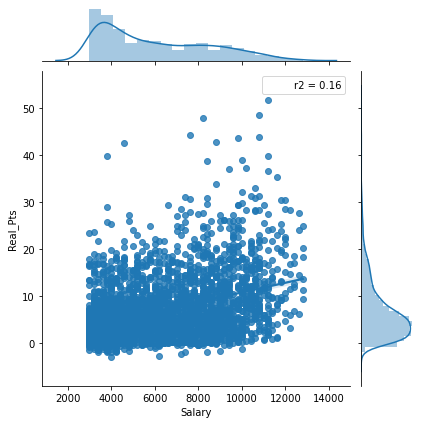

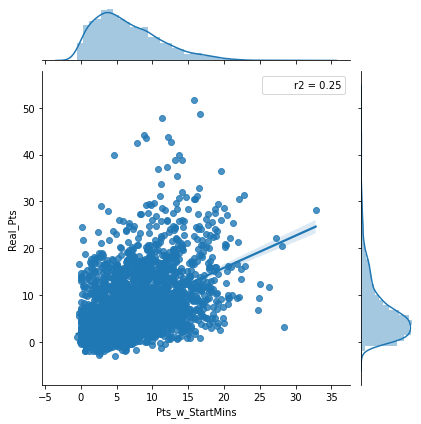

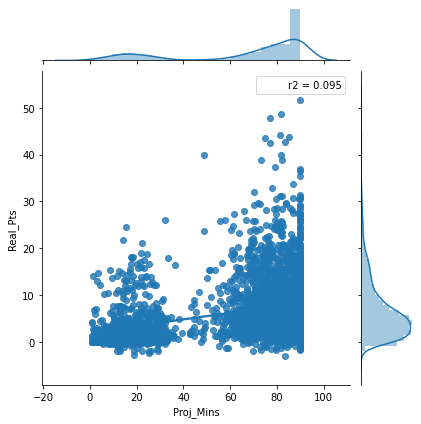

In [52]:
#fig, ax = plt.subplots(1,3, figsize=(21,7))
#ax[0].scatter(points_data['Salary'], points_data['Real_Pts'])
#ax[1].scatter(points_data['Pts_w_StartMins'], points_data['Real_Pts'])
#ax[2].scatter(points_data['Proj_Mins'], points_data['Real_Pts'])


from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

#fig, ax = plt.subplots(1,3, figsize=(21,7))
sns.jointplot(x='Salary', y='Real_Pts', data=points_data, kind='reg', stat_func=r2)
sns.jointplot(x='Pts_w_StartMins', y='Real_Pts', data=points_data, kind='reg', stat_func=r2)
sns.jointplot(x='Proj_Mins', y='Real_Pts', data=points_data, kind='reg', stat_func=r2)

### Get the stat projections using linear regression
#### This will find a file generated by an R script, which contains predictions for each upcoming game for the stats relevant to DFS
#### Ex: For an MLS game in the weekend of 8/13/21 to 8/15/21, the predictions are in the file: 'Regression_Matrices/MLS/MLS_predictions_matrix_20210813-20210815'

In [187]:
## Run this cell to get the shot and SoT projections
## Fill in the league to get the write patch to the shotlog file
#################################################################################################################

#league = "LaLiga"  # MLS, PremierLeague, Bundesliga, LaLiga, Ligue1, SerieA

#################################################################################################################
#filename = "Shotlogs/" + league + "_shotlog2021.csv"
#filename = 'Regression_Matrices/MLS/MLS_predictions_matrix_20210813-20210815.csv'

directory_name = 'Regression_Matrices/'+regression_league+'/'
directory_list = os.listdir(directory_name)
for file in directory_list:
    if ('predictions_matrix' in file):
        start_date = file.split('-')[0][-8:]
        end_date = file.split('-')[1][:-4]
        if (end_date[-1] not in ['1','2','3','4','5','6','7','8','9','0']):
            continue
        else:
            start_date = int(start_date)
            end_date = int(end_date)
        if (int(date) in range(start_date, end_date+1)):
            print('Found File:', file)
            break
full_preds = pd.read_csv(directory_name + file)
idx = full_preds[full_preds['Team'] == home_full].index[0]
predictions_matrix = full_preds.loc[idx:idx+1].reset_index().drop(columns=['index'])
predictions_matrix = predictions_matrix.rename(columns={'Pred.Goals':'Real_Goals', 'Pred.Sh':'Real_Sh', 'Pred.SoT':'Real_SoT',
                                                        'Pred.KP':'Real_KP', 'Pred.Fls':'Real_Fls', 'Pred.Fld':'Real_Fld',
                                                        'Pred.Crs':'Real_Crs', 'Pred.Int':'Real_Int', 'Pred.TklW':'Real_TklW'})
predictions_matrix

Found File: Bundesliga_predictions_matrix_20211105-20211107.csv


,Date,Team,Opp,League,Real_Goals,Real_Sh,Real_SoT,Real_KP,Real_Fls,Real_Fld,Real_Crs,Real_Int,Real_TklW
0,20211107,Greuther Fürth,Eint Frankfurt,Bundesliga,1.397957,13.533213,4.629000,10.027646,15.243367,13.193185,10.722326,18.188373,11.081643
1,20211107,Eint Frankfurt,Greuther Fürth,Bundesliga,1.275607,14.346706,4.549747,11.277434,12.614027,13.686858,11.469321,14.632706,10.946036


### Make sure you open the file to select which players are starting

In [188]:
starters = pd.read_csv("Matchup_Spreadsheets/"+league+'/'+home_abbrev+"_"+away_abbrev+"_"+date+"_spreadsheet.csv")
starters = starters[starters["Starting"].notna()]
starters = starters.reset_index().drop(columns=["index"])
starters = starters[starters["Pos"] != "GK"] # these projections really only work for field players, GKs are a different beast
starters = starters.reset_index().drop(columns=["index"])

# Make sure the minutes for each team sum to 990 (or 900 if a player is deliberately left out)
#starters = starters[starters['Starting'] == 'y']
#starters = starters.reset_index().drop(columns=["index"])
print(home_abbrev)
for k in range(10):
    home = starters[starters['Team'] == home_abbrev]
    target_mins = len(home[home['Starting'] == 'y'])*90
    real_mins = home[home['Starting'] == 'y']['Start_Mins'].sum() + home[home['Starting'] == 'b']['Sub_Mins'].sum()
    non_90s = home[~((home['Starting'] == 'y') & (home['Start_Mins'] == 90))]
    if (k==0):
        print('Target:', target_mins)
        print('Real:  ',real_mins)

    for i in non_90s.index:
        if (starters['Starting'][i] == 'y'):
            starters['Start_Mins'][i] = min([starters['Start_Mins'][i] * (target_mins/real_mins), 90])
        elif (starters['Starting'][i] == 'b'):
            starters['Sub_Mins'][i] = min(starters['Sub_Mins'][i] * (target_mins/real_mins), 45)
home = starters[starters['Team'] == home_abbrev]
print('Result:', home[home['Starting'] == 'y']['Start_Mins'].sum() + home[home['Starting'] == 'b']['Sub_Mins'].sum())
print('')

print(away_abbrev)
for k in range(10):
    away = starters[starters['Team'] == away_abbrev]
    target_mins = len(away[away['Starting'] == 'y'])*90
    real_mins = away[away['Starting'] == 'y']['Start_Mins'].sum() + away[away['Starting'] == 'b']['Sub_Mins'].sum()
    non_90s = away[~((away['Starting'] == 'y') & (away['Start_Mins'] == 90))]
    if (k==0):
        print('Target:', target_mins)
        print('Real:  ',real_mins)

    for i in non_90s.index:
        if (starters['Starting'][i] == 'y'):
            starters['Start_Mins'][i] = min([starters['Start_Mins'][i] * (target_mins/real_mins), 90])
        elif (starters['Starting'][i] == 'b'):
            starters['Sub_Mins'][i] = min(starters['Sub_Mins'][i] * (target_mins/real_mins), 45)
away = starters[starters['Team'] == away_abbrev]
print('Result:', away[away['Starting'] == 'y']['Start_Mins'].sum() + away[away['Starting'] == 'b']['Sub_Mins'].sum())
##print('')

#################################################################################################################
# Utilized predictions matrix that was read in earlier
starters_pre = starters.copy()
starters = make_finished_spreadsheet(starters, home_abbrev, away_abbrev, predictions_matrix, model)
X_test = np.array(starters[['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_med_w_mins']])
starters['XGB_Reg'] = xgb.XGBRegressor(**args).fit(X_med, y).predict(X_test)

starters[['Player', 'Team', 'Salary', '90s', 'Gls', 'Ast', 'Sh', 'SoT', 'Crs', 'KP', 'Pass_Cmp', 'Fld', 'Fls', 'TklW', 'Int', 'CrdY', 'Floor', 'FPTS',
         'xG', 'xA', 'Proj_Gls', 'Proj_Ast', 'Proj_Sh', 'Proj_SoT', 'Proj_KP', 'Proj_Crs', 'Proj_Fld', 'Proj_Fls', 'Proj_TklW', 'Proj_Int',
         'Pts_w_StartMins',  'Reg_Pts', 'FPTS_med_w_mins', 'XGB_Reg', 'Start_Mins', 'Sub_Mins', 'Starting', 'Player_']]

SGF
Target: 810
Real:   799.69404761
Result: 809.997127664018

SGE
Target: 900
Real:   941.6
Result: 900.0000040271598


,Player,Team,Salary,90s,Gls,Ast,Sh,SoT,Crs,KP,Pass_Cmp,Fld,Fls,TklW,Int,CrdY,Floor,FPTS,xG,xA,Proj_Gls,Proj_Ast,Proj_Sh,Proj_SoT,Proj_KP,Proj_Crs,Proj_Fld,Proj_Fls,Proj_TklW,Proj_Int,Pts_w_StartMins,Reg_Pts,FPTS_med_w_mins,XGB_Reg,Start_Mins,Sub_Mins,Starting,Player_
0,Filip Kostic,SGE,11400,6.144444,2,4,11,5,39,20,155,8,5,6,2,1,12.840868,19.757685,0.4,2.1,0.090537,0.485775,2.329581,1.048202,4.295463,4.735547,1.334817,0.673689,0.775971,0.260861,17.172706,14.175808,14.411415,14.118736,82.090337,32.000000,y,Filip Kostic
1,Branimir Hrgota,SGF,9000,7.055556,2,1,7,2,8,13,120,17,9,7,5,1,7.370079,10.842520,2.1,1.5,0.472292,0.629241,1.353122,0.329039,2.535166,1.096720,1.854958,1.107713,0.826791,0.727818,16.281928,12.531274,8.205757,10.795517,81.155843,0.000000,y,Branimir Hrgota
2,Jamie Leweling,SGF,7800,3.155556,1,0,7,3,7,2,34,9,4,1,3,0,8.581690,11.750704,0.8,0.1,0.446128,0.104017,3.355174,1.223818,0.967099,2.379480,2.435038,1.220740,0.292871,1.082810,15.171544,11.748318,6.660000,9.538325,90.000000,17.333333,y,Jamie Leweling
3,Daichi Kamada,SGE,9800,5.533333,0,0,7,2,6,7,139,7,7,6,7,0,6.502410,6.502410,0.9,0.5,0.220389,0.125131,1.603847,0.453612,1.626514,0.788200,1.263599,1.020393,0.839509,0.987772,9.723653,10.311812,5.766387,10.274610,79.978992,37.500000,y,Daichi Kamada
4,Rafael Borre,SGE,8400,6.311111,1,0,11,3,10,3,120,10,12,10,2,0,6.559859,8.144366,1.2,0.1,0.261901,0.022305,2.246294,0.606436,0.621284,1.170831,1.608868,1.559048,1.247048,0.251535,9.592127,9.567268,6.329278,8.986633,81.302521,26.000000,y,Rafael Borre
5,Erik Durm,SGE,8200,3.766667,0,1,1,0,10,3,143,5,2,3,9,1,6.732743,7.927434,0.0,0.6,0.000000,0.214458,0.327235,0.000000,0.995580,1.876206,1.289070,0.416384,0.599502,1.813828,7.166206,8.384537,5.339338,8.441515,77.757353,0.000000,y,Erik Durm
6,Martin Hinteregger,SGE,6600,8.000000,1,0,8,2,2,1,348,16,8,12,15,2,6.357500,7.232500,0.6,0.2,0.114357,0.038957,1.426653,0.353060,0.180852,0.204493,2.247992,0.907659,1.306829,1.647454,8.275738,8.382628,7.240000,7.680585,90.000000,0.000000,y,Martin Hinteregger
7,Julian Green,SGF,7000,3.355556,0,0,4,3,9,4,74,8,5,4,7,1,9.470861,9.023841,0.0,0.1,0.000000,0.077231,1.423530,0.908671,1.436120,2.271518,1.607100,1.132981,0.869812,1.875940,9.018402,8.270819,6.670099,8.547405,71.059289,24.000000,y,Julian Green
8,Cedric Itten,SGF,4800,4.866667,1,0,10,7,4,3,59,6,12,6,0,1,6.160274,7.906849,1.1,0.1,0.356966,0.060530,2.789214,1.661722,0.844165,0.791241,0.944668,2.131126,1.022567,0.000000,10.901087,8.178059,4.218116,6.952597,80.772429,21.500000,y,Cedric Itten
9,Hans Nunoo Sarpei,SGF,3600,3.000000,0,0,1,0,0,0,111,10,1,8,8,0,8.240000,8.240000,0.0,0.0,0.000000,0.000000,0.504164,0.000000,0.000000,0.000000,2.845888,0.321009,2.464452,3.037216,7.912608,6.662615,8.480000,6.705314,90.000000,0.000000,y,Hans Nunoo Sarpei


### Optimizer to get best lineups

In [189]:
#target_stat = 'FPTS_med_w_mins'
target_stat = 'Reg_Pts'

full_starters = starters.copy()
starters = starters[starters['Starting'] == 'y']
min_pts = starters[target_stat].mean() * (5.5*1.25)
start = time.time()
Lineups_DF = pd.DataFrame(columns=['Captain', 'Flex1', 'Flex2', 'Flex3', 'Flex4', 'Flex5', 'Proj_Pts', 'Price'],
                          index=range(len(starters) *len(list(itertools.combinations(range(len(starters)-1), 5)))))

i=0
for cpt_idx in list(starters.index):
    full_idxs = list(starters.index)
    full_idxs.remove(cpt_idx)
    full_idxs
    index_combos = list(itertools.combinations(full_idxs, 5))
    for index_combo in index_combos:
        if (len(set([starters['Team'][cpt_idx], starters['Team'][index_combo[0]], starters['Team'][index_combo[1]], starters['Team'][index_combo[2]], starters['Team'][index_combo[3]], starters['Team'][index_combo[4]]])) > 1):
            price = starters['Salary'][cpt_idx]*1.5 + \
                        starters['Salary'][index_combo[0]] + \
                        starters['Salary'][index_combo[1]] + \
                        starters['Salary'][index_combo[2]] + \
                        starters['Salary'][index_combo[3]] + \
                        starters['Salary'][index_combo[4]]
            proj_pts = starters[target_stat][cpt_idx]*1.5 + \
                        starters[target_stat][index_combo[0]] + \
                        starters[target_stat][index_combo[1]] + \
                        starters[target_stat][index_combo[2]] + \
                        starters[target_stat][index_combo[3]] + \
                        starters[target_stat][index_combo[4]]
            Lineups_DF.loc[i] = [starters['Player'][cpt_idx], starters['Player'][index_combo[0]], starters['Player'][index_combo[1]], starters['Player'][index_combo[2]],
                                 starters['Player'][index_combo[3]], starters['Player'][index_combo[4]], proj_pts, price]
        i+=1

Lineups_DF = Lineups_DF[Lineups_DF['Price'] <= 50000]
Lineups_DF = Lineups_DF[Lineups_DF['Proj_Pts'] > min_pts]
Lineups_DF = Lineups_DF.sort_values(by='Proj_Pts', ascending=False).reset_index().drop(columns=['index'])

stop = time.time()
print('Total Time:', round(stop-start), 'sec')
Lineups_DF

Total Time: 63 sec


,Captain,Flex1,Flex2,Flex3,Flex4,Flex5,Proj_Pts,Price
0,Branimir Hrgota,Filip Kostic,Jamie Leweling,Rafael Borre,Cedric Itten,Hans Nunoo Sarpei,69.12898,49500.0
1,Branimir Hrgota,Filip Kostic,Jamie Leweling,Rafael Borre,Cedric Itten,Paul Seguin,68.830308,49700.0
2,Filip Kostic,Branimir Hrgota,Jamie Leweling,Martin Hinteregger,Cedric Itten,Hans Nunoo Sarpei,68.766607,48900.0
3,Jamie Leweling,Filip Kostic,Branimir Hrgota,Rafael Borre,Cedric Itten,Hans Nunoo Sarpei,68.737501,48900.0
4,Jamie Leweling,Filip Kostic,Branimir Hrgota,Daichi Kamada,Cedric Itten,Kristijan Jakic,68.715543,49900.0
...,...,...,...,...,...,...,...,...
46770,Rafael Borre,Branimir Hrgota,Cedric Itten,Hans Nunoo Sarpei,Djibril Sow,Kristijan Jakic,54.084034,37400.0
46771,Jamie Leweling,Martin Hinteregger,Julian Green,Cedric Itten,Max Christiansen,Obite N'Dicka,54.083818,38300.0
46772,Cedric Itten,Branimir Hrgota,Jamie Leweling,Hans Nunoo Sarpei,Obite N'Dicka,Tuta,54.083628,35600.0
46773,Kristijan Jakic,Branimir Hrgota,Daichi Kamada,Rafael Borre,Djibril Sow,Paul Seguin,54.083538,40000.0


In [190]:
Lineups_DF[Lineups_DF['Proj_Pts'] >= Lineups_DF['Proj_Pts'].max()-1].sort_values(by='Price', ascending=False)
#Lineups_DF.iloc[:100]
#Lineups_DF[Lineups_DF['Price'] >= 49000]

,Captain,Flex1,Flex2,Flex3,Flex4,Flex5,Proj_Pts,Price
4,Jamie Leweling,Filip Kostic,Branimir Hrgota,Daichi Kamada,Cedric Itten,Kristijan Jakic,68.715543,49900.0
9,Filip Kostic,Branimir Hrgota,Jamie Leweling,Julian Green,Cedric Itten,Djibril Sow,68.457255,49900.0
16,Filip Kostic,Branimir Hrgota,Jamie Leweling,Rafael Borre,Hans Nunoo Sarpei,Paul Seguin,68.137131,49700.0
1,Branimir Hrgota,Filip Kostic,Jamie Leweling,Rafael Borre,Cedric Itten,Paul Seguin,68.830308,49700.0
15,Jamie Leweling,Filip Kostic,Branimir Hrgota,Rafael Borre,Cedric Itten,Jetro Willems,68.257527,49700.0
14,Filip Kostic,Branimir Hrgota,Jamie Leweling,Martin Hinteregger,Cedric Itten,Jetro Willems,68.286633,49700.0
13,Filip Kostic,Branimir Hrgota,Jamie Leweling,Julian Green,Cedric Itten,Paul Seguin,68.356126,49500.0
11,Branimir Hrgota,Filip Kostic,Jamie Leweling,Rafael Borre,Cedric Itten,Max Christiansen,68.422948,49500.0
0,Branimir Hrgota,Filip Kostic,Jamie Leweling,Rafael Borre,Cedric Itten,Hans Nunoo Sarpei,69.12898,49500.0
7,Jamie Leweling,Filip Kostic,Branimir Hrgota,Rafael Borre,Cedric Itten,Djibril Sow,68.539958,49500.0


In [191]:
print('1:',len(Lineups_DF[Lineups_DF['Proj_Pts'] >= Lineups_DF['Proj_Pts'].max()-1]))
print('2:',len(Lineups_DF[Lineups_DF['Proj_Pts'] >= Lineups_DF['Proj_Pts'].max()-2]))
print('3:',len(Lineups_DF[Lineups_DF['Proj_Pts'] >= Lineups_DF['Proj_Pts'].max()-3]))
print('4:',len(Lineups_DF[Lineups_DF['Proj_Pts'] >= Lineups_DF['Proj_Pts'].max()-4]))
print('5:',len(Lineups_DF[Lineups_DF['Proj_Pts'] >= Lineups_DF['Proj_Pts'].max()-5]))
            

1: 17
2: 93
3: 260
4: 618
5: 1237


In [192]:
Lineups_DF.to_csv("Generated_Lineups/"+league+"/"+home_abbrev+"_"+away_abbrev+"_"+date+"_lineups.csv")